# 패키지 불러오기

In [25]:
from math import log
from collections import Counter
from konlpy.tag import Mecab
from textrank import KeysentenceSummarizer
from textrank import KeywordSummarizer
from python_utils import logger
from wordcloud import WordCloud

import pandas as pd
import numpy as np                                                       
import os, re, time, csv
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import json
import operator

%matplotlib inline
mecab = Mecab()

# 함수정의

In [26]:
# 형태소 분석 전처리 함수
# texts = 문장

def change_sents(texts):
    mecab = Mecab()
    sents_new = []
    for i in range(len(texts)):
        a = mecab.pos( phrase=texts[i], flatten=True)
        result = []
        for j in range(len(a)):
            b = a[j][0] + '/' + a[j][1]
            if j == len(a)-1:
                result.append(b)
            else:
                result.append(b)
                result.append(' ')
        result1 = ''
        for i in result:
            result1 += i
        sents_new.append(result1)

    return sents_new

In [27]:
def mecab_tokenize(sent):
    words = sent.split()
#     words = [w for w in words if ('/NN' in w or '/XR' in w or '/VA' in w or '/VV' in w)]
    words = [w for w in words if ('/NN' in w and list(w)[1]!='/' and '이랑' not in w)] 
    return words

def textrank_key_word(sent, n):
    keyword_extractor = KeywordSummarizer(
        tokenize = mecab_tokenize,
        window = -1,
        verbose = False
    )
    keywords = keyword_extractor.summarize(sents, topk=n)
    KEYWORD  = []
    RANK = []
    
    for word, rank in keywords:
        temp = list(word)
        del temp[-4:]
        temp = "".join(temp)
        KEYWORD.append(temp)
        RANK.append(rank)

    key_word = []
    rank = []
    for i in range(len(KEYWORD)):
        if KEYWORD[i] not in key_word:
            key_word.append(KEYWORD[i])
            rank.append(RANK[i])
    
    return key_word, rank

In [28]:
# 빈도기반 키워드 추출 함수
# text = 문장, n = 키워드 개수

def prob_key_word(text,n):
    word_list_1 = []
    mecab = Mecab()
    for i in range(len(text)):
        a = mecab.nouns(phrase=text[i])
        for keyword in a:
            word_list_1.append(keyword)
    word_list_1 = list(filter(lambda x: len(x)>1, word_list_1))
    count = Counter(word_list_1)
    noun_list = count.most_common(n)
    keyword = []
    keyword_cnt = []
    for key, cnt in noun_list:
        keyword.append(key)
        keyword_cnt.append(cnt)
        
    return keyword, keyword_cnt

In [29]:
# 키워드 딕셔너리 생성 함수
# keyword = 키워드 추출 함수에서 나온 결과, text = 문장

def keyword_dic(keyword, text):
    dic = {}
    for k_word in keyword[0]:
        dic[k_word]=[]
    for k_word in keyword[0]:
        for sentence in text:
            if k_word in sentence:
                dic[k_word].append(sentence)
                
    return dic

In [30]:
# 한 문장씩 분할 함수 ('.' 포함)
# text = 문장 전체

def split_sentence_dot(text):
    temp = text.split('.')
    del temp[-1]
    texts = []

    for sen in temp:
        sen = sen.strip()
        sen += '.'
        texts.append(sen)
    return texts

In [31]:
# 한 문장씩 분할 함수 ('.' 미포함)
# text = 문장 전체

def split_sentence(text):
    temp = text.split('.')
    del temp[-1]
    texts = []
    
    for sen in temp:
        sen = sen.strip()
        texts.append(sen)
    return texts

In [32]:
# 핵심 문장 추출
# texts = 문장, n = 추출 문장 개수

def mecab_tokenizer(sent):
    words = mecab.pos(sent, join=True)
#     words = [w for w in words if ('/NN' in w or '/XR' in w or '/VA' in w or '/VV' in w)]
    words = [w for w in words if ('/NN' in w and list(w)[1]!='/')]
    return words

def summarizer_text(texts, n):
    summarizer = KeysentenceSummarizer(
        tokenize = mecab_tokenizer,
        min_sim = 0.3,
        verbose = False
    )
    sent = []
    keysents = summarizer.summarize(texts, topk=n)

    for _, _, a in keysents:
        sent.append(a)
    
    final_sent = []
    
    for i in texts:
        if i in sent:
            final_sent.append(i)
    
    return final_sent

In [33]:
# WordCloud 생성 함수
# texts = 문장

def wordcloud(texts):
    font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
    fontprop = fm.FontProperties(fname=font_path, size=18)
    file_name = 'wordcloud'
#     png('word', 1000, 1000)
    wc = WordCloud(font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",
                  background_color = "white",
                  width=1000,
                  height=1000,
                  max_words=100,
                  max_font_size=300)
    
    mecab = Mecab()
    total_text = ' '.join(texts)

    noun = mecab.nouns(total_text)
    for i, v in enumerate(noun):
        if len(v)<2:
            noun.pop(i)
    count = Counter(noun)
    noun_list = count.most_common(100)
    
    wordcloud_words = wc.generate_from_frequencies(dict(noun_list))
    fig = plt.figure(figsize = (10,10))
    plt.imshow(wordcloud_words,interpolation='bilinear')
    plt.axis("off")
#     dev.off()
    plt.savefig(file_name)
    plt.show()
#     savePlot(wordcloud, type = 'png')

In [34]:
# text 시간대별 분할 함수
# text = 문장, n = 분할 개수

def split_texts(text, n):
    split_texts = []
    len_texts = len(texts)

    if (len_texts % n) == 0:
        number = len_texts//n
    else:
        number = len_texts//n + 1

    for i in range(n):
        if i == n-1:
            split_texts.append(texts[(i*number):])
        else:
            split_texts.append(texts[(i*number):(i+1)*number])
    return split_texts

In [35]:
# 시간대별 키워드 추출 함수
# split_text = split_texts 함수 결과, n = 키워드 개수

def split_keyword(split_text, n):
    split_keyword = []
    
    for i in range(len(split_text)):
        split_keyword.append((prob_key_word(split_text[i], n)[0], prob_key_word(split_text[i], n)[1]))
    return split_keyword

In [36]:
# chart 생성 함수
# split_keyword = split_keyword 함수 결과

def chart(split_keyword):
    font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
    fontprop = fm.FontProperties(fname=font_path, size=18)
    MAX = 0
    title = ['초반', '중반', '후반']
    
    for i in range(len(split_keyword)):
        max_value = max(split_keyword[i][1])
        if MAX < max_value:
            MAX = max_value
    
    for i in range(len(split_keyword)):
        x = np.arange(len(split_keyword[0][0]))
        keyword = split_keyword[i][0]
        cnt = split_keyword[i][1]
        name = 'chart' + str(i+1) + '.png'
        title_name = title[i]
        plt.bar(x, cnt)
        plt.xticks(x, keyword, fontproperties=fontprop)
        plt.xticks(size = 20)
        plt.yticks(size = 20)
        plt.ylim([0, MAX])
        plt.title(title_name, fontproperties=fontprop, size = 30)
        plt.savefig(name)
        plt.show()
        

In [37]:
def chart2(texts, keyword_list, n=5):
    split_text1 = split_texts(texts, n)
    cnt = 0
    ls = []
    final = []

    for key in keyword_list:
        for j in range(len(split_text1)):
            for i in split_text1[j]:
                if key in i:
                    cnt += 1
            ls.append(cnt)
            cnt = 0
        final.append(ls)
        ls = []
        
    k_dic = {}
    for i in range(len(keyword_list)):
        k_dic[keyword_list[i]] = final[i]
    
    df = pd.DataFrame(k_dic)
    df.index = ['초반', '초중반', '중반', '중후반', '후반']
    
    font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
    fontprop = fm.FontProperties(fname=font_path, size=18)
    font_name = fm.FontProperties(fname=font_path, size=18).get_name()
    plt.rc('font', family = font_name)

    plt.rcParams['figure.figsize'] = [15, 8]
    plt.plot(df.index, df[keyword_list[0]], marker='o', color='r', )
    plt.plot(df.index, df[keyword_list[1]], marker='*', color='b')
    plt.plot(df.index, df[keyword_list[2]], marker='+', color='y')
    plt.xticks(size = 20)
    plt.yticks(size = 20)


    plt.title('시간대별 키워드', fontsize=30) 


    plt.legend(keyword_list, fontsize=18, loc='best')
    plt.savefig('chart4')
    plt.show()


In [38]:
# 화자별 키워드 발화수 계산
# keyword = 키워드 추출 함수 결과, texts = 문장, dataframe = 화자, 발화 내용 df


def keyword_member(keyword, texts, dataframe):
    member = []
    keyword_dict = keyword_dic(keyword, texts)
    
    for i in keyword[0]:
        for j in range(len(keyword_dict[i])):
            a = list(dataframe[dataframe['contents'] == keyword_dict[i][j]]['username'])
            member.append(a[0])

    count = Counter(member)
    Keyword_member = count.most_common(100)
    return Keyword_member

In [39]:
# 화자별 문장 발화수 계산
# dataframe = 화자, 발화 내용 df

def total(dataframe):
    member_total = list(dataframe['username'])

    count = Counter(member_total)
    total_member = count.most_common(100)
    
    return total_member

In [40]:
# 화자 집중도 분석 함수

def total_text(texts):
    total_text = len(texts)
    return total_text

def speak_text(dataframe):
    speak_text = dataframe.groupby(by= ['username']).count()
    name_list = list(speak_text.index)
    val_list = list(speak_text['contents'])
    speak_text=list(zip(name_list, val_list))
    return speak_text

def total_keyword(texts, keyword):
    total_keyword = 0
    for i in texts:
        for j in keyword[0]: 
            if j in i:
                total_keyword += 1
    return total_keyword

def speak_keyword(dataframe, keyword):
    dic = {}
    speak_keyword = list(dataframe.groupby(by=['username']))
    for i in speak_keyword:
        dic[i[0]] = list(i[1]['contents'])
    cnt = 0
    name_list = []
    val_list = []
    for key, val in dic.items():
        name_list.append(key)
        for i in dic[key]:
            for j in keyword[0]:
                if j in i:
                    cnt +=1
        val_list.append(cnt)
        cnt = 0
    speak_keyword=list(zip(name_list, val_list))
    return speak_keyword

def concentration(total_text, speak_text, total_keyword, speak_keyword, w):
    speak_text.sort(key = lambda x : x[0])
    speak_keyword.sort(key = lambda x : x[0])
    best_member = {}
    
    for i in range(len(speak_text)):
        concentration = (w * (speak_text[i][1]/total_text) + (1-w) * (speak_keyword[i][1]/total_keyword))*100
        best_member[speak_text[i][0]] = concentration
    
    return best_member

# -------------------------------------------------------------------------------------------------------------

### json 불러오기

In [41]:
with open('test2.json') as datafile:
    data = json.load(datafile)
dataframe = pd.DataFrame(data)
dataframe.columns = ['roomid', 'time', 'username', 'contents']
dataframe

,roomid,time,username,contents
0,thursday,00:20:04,김영욱,이렇게 천천히 말해야 인식
1,thursday,00:20:10,오재일,아닌데
2,thursday,00:20:16,박성건,자 오늘 회의 안건은
3,thursday,00:20:19,박성건,오늘 야식 뭐 먹을까
4,thursday,00:20:22,김수경,나 너무 재미가 없어 나도 오디오로 하나 더 볼래
...,...,...,...,...
314,thursday,00:44:21,김영욱,아니 아니 그냥 내 거를 해 보려고 하는게 아니라
315,thursday,00:44:26,김영욱,사람들
316,thursday,00:44:38,김영욱,계속 놀고 있어
317,thursday,00:45:14,김영욱,콘솔 로그 찍기


In [42]:
texts = list(dataframe['contents'])
sents = change_sents(texts)

### 멤버

In [43]:
member = tuple(set(dataframe['username']))
member

('김수경', '최인경', '배민진', '오재일', '박성건', '김영욱')

### 키워드 추출 (textrank, 빈도)

In [44]:
keyword_textrank = textrank_key_word(sents, 3)
keyword_textrank

(['자연어', '오늘', '회의'],
 [2.0979752195055705, 2.0050868835377385, 1.9958930953536105])

In [45]:
keyword_list = keyword_textrank[0]
keyword_list

['자연어', '오늘', '회의']

In [46]:
keyword_prob = prob_key_word(texts, 3)

### 키워드별 요약문

In [47]:
keyword_dict = keyword_dic(keyword_textrank, texts)
keyword_dict

{'자연어': ['근데 자연어처리 조교님이기 때문에 자연어처리의 관련해서 물어봐야 해 근데 이거는 나랑 영국사랑 오늘 민서랑 이따가 한번 해 보고 말씀 드리는 걸로 정하는게 나을 것 같기도 해',
  '아 맞다 수경 나 나중에 너한테 전화해서 자연어 처리 관련해서 물어볼 거 있음',
  '근데 와서 할 일 많아 우리 자연어 처리 할 거 개 많아'],
 '오늘': ['자 오늘 회의 안건은',
  '오늘 야식 뭐 먹을까',
  '그럼 조장님 오늘 회 한 건이 뭡니까',
  '근데 자연어처리 조교님이기 때문에 자연어처리의 관련해서 물어봐야 해 근데 이거는 나랑 영국사랑 오늘 민서랑 이따가 한번 해 보고 말씀 드리는 걸로 정하는게 나을 것 같기도 해',
  '오늘 나감',
  '나머지 수경이는 수경이랑 영국 바는 오늘까지 그거 모델 완성하고 자기 전까지',
  '오늘 고생하셨습니다 회의 끝'],
 '회의': ['자 오늘 회의 안건은',
  '근데 회의 다운 회의를 해야 우리가 테스트 요약을 하나 뽑아 볼 수 있을 텐데',
  '그 우리가 회의록을 통해서',
  '그 내용이 있어야지 회의록 데이터를 통해서 이거를 이거를 모델링을',
  '회의 같은 회의를 못 한 거 같다',
  'ok 그러면 그걸 회의록을 일단 한번 하고 이걸로 해보겠다는 거지',
  '그러면 여기까지 끝 회의록은 내가 올려 놔 줄게 다 같이 볼 수 있게',
  '오늘 고생하셨습니다 회의 끝',
  '근데 고생하셨습니다 회의 끝']}

In [49]:
keyword1 = keyword_dict[keyword_textrank[0][0]]
keyword2 = keyword_dict[keyword_textrank[0][1]]
keyword3 = keyword_dict[keyword_textrank[0][2]]

keyword1 = summarizer_text(keyword1, 5)
keyword2 = summarizer_text(keyword2, 5)
keyword3 = summarizer_text(keyword3, 5)

keyword_dict[keyword_textrank[0][0]] = summarizer_text(keyword1, 10)
keyword_dict[keyword_textrank[0][1]] = summarizer_text(keyword2, 10)
keyword_dict[keyword_textrank[0][2]] = summarizer_text(keyword3, 10)

In [50]:
keyword_dict

{'자연어': ['근데 자연어처리 조교님이기 때문에 자연어처리의 관련해서 물어봐야 해 근데 이거는 나랑 영국사랑 오늘 민서랑 이따가 한번 해 보고 말씀 드리는 걸로 정하는게 나을 것 같기도 해',
  '아 맞다 수경 나 나중에 너한테 전화해서 자연어 처리 관련해서 물어볼 거 있음',
  '근데 와서 할 일 많아 우리 자연어 처리 할 거 개 많아'],
 '오늘': ['자 오늘 회의 안건은',
  '근데 자연어처리 조교님이기 때문에 자연어처리의 관련해서 물어봐야 해 근데 이거는 나랑 영국사랑 오늘 민서랑 이따가 한번 해 보고 말씀 드리는 걸로 정하는게 나을 것 같기도 해',
  '오늘 나감',
  '나머지 수경이는 수경이랑 영국 바는 오늘까지 그거 모델 완성하고 자기 전까지',
  '오늘 고생하셨습니다 회의 끝'],
 '회의': ['자 오늘 회의 안건은',
  '근데 회의 다운 회의를 해야 우리가 테스트 요약을 하나 뽑아 볼 수 있을 텐데',
  '회의 같은 회의를 못 한 거 같다',
  '오늘 고생하셨습니다 회의 끝',
  '근데 고생하셨습니다 회의 끝']}

### 집중도

In [51]:
total_t = total_text(texts)
speak_t = speak_text(dataframe)
total_k = total_keyword(texts, keyword_prob)
speak_k = speak_keyword(dataframe, keyword_prob)
w = 0.5

best_member = concentration(total_t, speak_t, total_k, speak_k, w)

best_member = sorted(best_member.items(), key = lambda item: item[1], reverse=True)
best_member = dict(best_member)
best_member

{'오재일': 24.06896551724138,
 '김영욱': 22.971786833855802,
 '최인경': 18.777429467084637,
 '배민진': 16.426332288401255,
 '김수경': 9.172413793103448,
 '박성건': 8.58307210031348}

### 시각자료

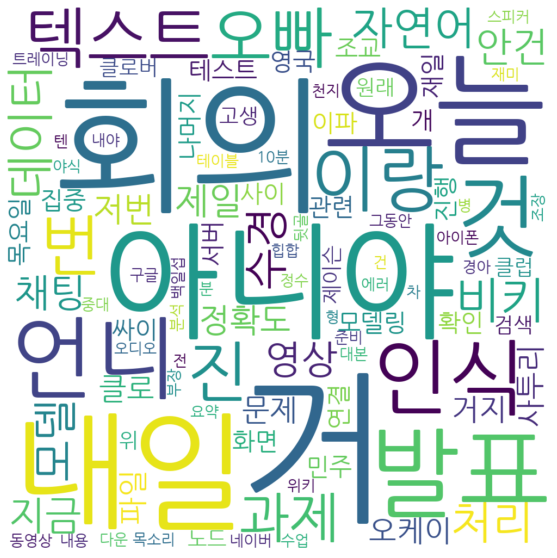

In [52]:
wordcloud(texts)

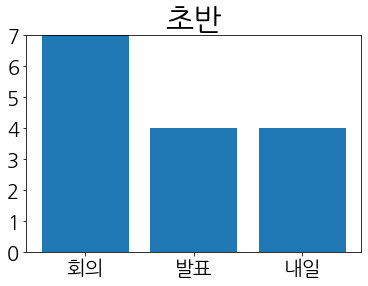

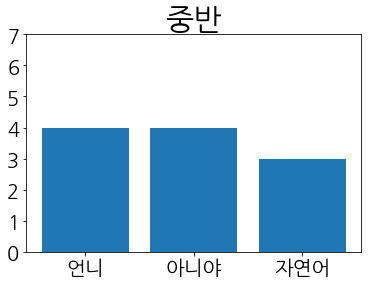

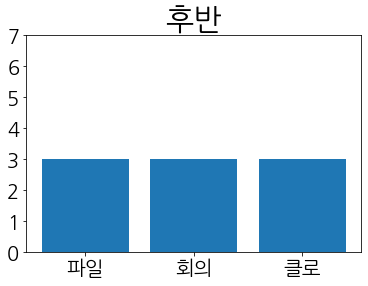

In [53]:
split_text = split_texts(texts, 3)
split_keywords = split_keyword(split_text, 3)
chart(split_keywords)

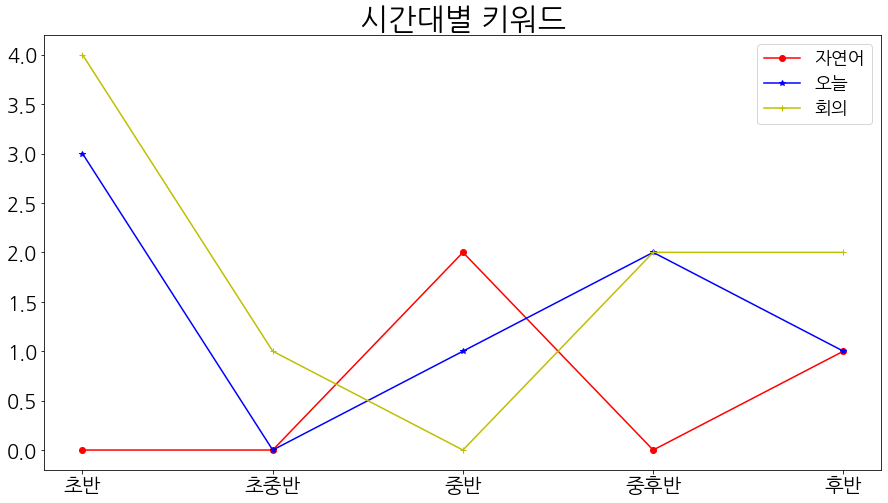

In [54]:
chart2(texts, keyword_list)

In [55]:
sample = {
    "date": "2020.12.29",
    "author": "도담도담(https://dodamdodam.site)",
    "member": member,
    "keywords": keyword_list,
    "summary": keyword_dict,
    "grade": best_member,
    "record": [
            {
            "roomid": "6566259168927733",
            "time": "17:06:56",
            "userid": "bf226qv1qdp",
            "username": "배민진",
            "contents": "테스트 시작하겠습니다"
            },
           {
            "roomid": "6566259168927733",
            "time": "17:06:56",
            "userid": "bf226qv1qdp",
            "username": "오재열",
            "contents": "테스트 시작하겠습니다"
            },
    ]
}

### -----------------------------밑에는 필요없음-------------------------------------

In [18]:
with open('./meeting.txt', encoding='utf-8') as f:
    texts = [sent.strip() for sent in f]
texts

['[배민진] [오후 7:17] 자 다들 모였으니 회의 시작하겠습니다',
 '[배민진] [오후 7:17] 이번 회의는 저번 회의에서 말했듯이 화상회의 서비스에 대한 사전조사를 바탕으로 브리핑 해주시면 됩니다',
 '[배민진] [오후 7:18] 먼저 스카이프부터 브리핑 부탁드립니다',
 '[오재일] [오후 7:18] 네 알겠습니다',
 '[오재일] [오후 7:19] 스카이프는 여러 사람이 실시간으로 원격 상호작용할 수 있는 마이크로소프트의 통신 도구입니다',
 '[오재일] [오후 7:21] 처음에는 인터넷을 통한 음성 통화를 위해 고안됐고 음성 통화 부분에서는 여전히 스카이프의 주요 기능입니다',
 '[오재일] [오후 7:21] 현재는 영상통화와 인스턴트 메세지 서비스 또한 제공합니다',
 '[오재일] [오후 7:22] 최근 신종 코로나 바이러스 격리 기간 동안 크게 홍보된 미트나우라는 기능을 앞세워 경쟁력을 높이고 있습니다',
 '[오재일] [오후 7:22] 이 기능은 컴퓨터에 스카이프 소프트웨어가 다운로드 되어 있지 않더라도 무료 회의를 만들고 공유할 수 있는 기능입니다',
 '[오재일] [오후 7:23] 이는 단순한 사용자 환경과 높은 편의성으로 영상회의 솔루션 줌이 주목을 받자 영향을 받은 것으로 보입니다',
 '[오재일] [오후 7:23] 스카이프는 윈도우, 맥OS, 리눅스, 안드로이드, iOS, 엑스박스, 아마존 알렉사 기기와 호환됩니다',
 '[오재일] [오후 7:24] 또한 워드, 원드라이브, 아웃룩 등 다른 마이크로소프트 제품과 통합되며 슬랙과 워드프레스 같은 서드파티 앱과도 통합됩니다',
 '[오재일] [오후 7:24] 추가로 스카이프는 모든 스카이프간 통신을 무료로 사용할 수 있습니다',
 '[오재일] [오후 7:25] 여기에는 인터넷을 통한 화상 회의, 채팅, 음성 통화가 포함됩니다',
 '[오재일] [오후 7:26] 만약 다른 스마트폰이나 유선 전화로 전화하고 싶다면, 스카이프 크레딧을 구입하거나 요금제에 가입해야 합니다',
 '[오재일]

In [19]:
name = []
for i in range(len(texts)):
    name.append(texts[i][1:4])
    
content = []
for i in range(len(texts)):
    content.append(texts[i][16:])
    
dataframe = pd.DataFrame({'username' : name, 
                          'contents' : content})
dataframe

,username,contents
0,배민진,자 다들 모였으니 회의 시작하겠습니다
1,배민진,이번 회의는 저번 회의에서 말했듯이 화상회의 서비스에 대한 사전조사를 바탕으로 브리...
2,배민진,먼저 스카이프부터 브리핑 부탁드립니다
3,오재일,네 알겠습니다
4,오재일,스카이프는 여러 사람이 실시간으로 원격 상호작용할 수 있는 마이크로소프트의 통신 도...
...,...,...
60,배민진,이러한 시스코 웹엑스의 단점은 화상 강의 전문 플랫폼이다 보니 학습자료 탑재를 위한...
61,배민진,또한 비디오 오디오 품질이 다른 리더 사업자에 비해 낮은 편입니다
62,오재일,화상회의 제공해주는 서비스들이 이렇게 많았다는게 신기하네요
63,오재일,현재까지 조사한 화상회의 서비스들의 공통적인 문제점에 대해 추가적으로 조사해보고 저...


In [20]:
texts = list(dataframe['contents'])
sents = change_sents(texts)

In [21]:
keyword_prob = prob_key_word(texts, 6)

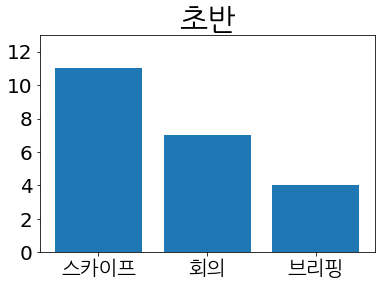

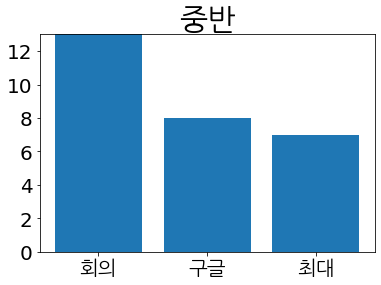

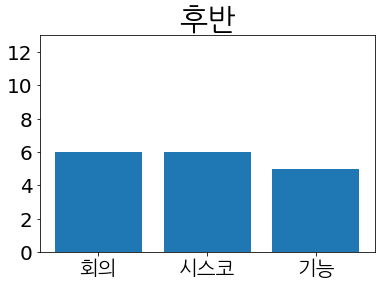

In [22]:
split_text = split_texts(texts, 3)
split_keywords = split_keyword(split_text, 3)
chart(split_keywords)

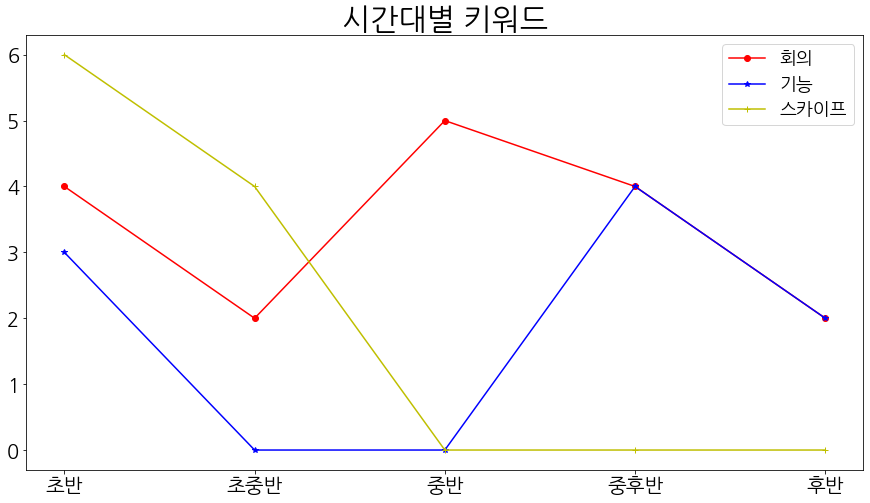

In [23]:
keyword_list = keyword_prob[0]
keyword_list
chart2(texts, keyword_list)